In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from google.colab import files
import io

### **STEP 1: LOAD DATA**

In [2]:
try:
    # Try reading the file locally (if you uploaded it via the sidebar)
    print("Attempting to read 'VIW_FID_EPI.csv'...")
    df = pd.read_csv('VIW_FID_EPI.csv')
    print("File loaded successfully!")
except FileNotFoundError:
    # If not found, prompt the user to upload it
    print("File not found. Please upload 'VIW_FID_EPI.csv' now:")
    uploaded = files.upload()
    filename = list(uploaded.keys())[0]
    df = pd.read_csv(io.BytesIO(uploaded[filename]))

Attempting to read 'VIW_FID_EPI.csv'...


/tmp/ipython-input-421229133.py:4: DtypeWarning: Columns (28,29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('VIW_FID_EPI.csv')


File loaded successfully!


In [3]:
print("BEFORE CONVERSION")
print("Data Type:", df['ISO_WEEKSTARTDATE'].dtype)
print("First 5 values:\n", df['ISO_WEEKSTARTDATE'].head())

BEFORE CONVERSION
Data Type: object
First 5 values:
 0    2024-01-22
1    2024-01-22
2    2024-01-22
3    2024-01-22
4    2024-12-02
Name: ISO_WEEKSTARTDATE, dtype: object


In [4]:
# Convert date column to datetime objects
df['ISO_WEEKSTARTDATE'] = pd.to_datetime(df['ISO_WEEKSTARTDATE'])

In [5]:
print("AFTER CONVERSION")
print("Data Type:", df['ISO_WEEKSTARTDATE'].dtype)
print("First 5 values:\n", df['ISO_WEEKSTARTDATE'].head())

AFTER CONVERSION
Data Type: datetime64[ns]
First 5 values:
 0   2024-01-22
1   2024-01-22
2   2024-01-22
3   2024-01-22
4   2024-12-02
Name: ISO_WEEKSTARTDATE, dtype: datetime64[ns]


### **STEP 2: PREPROCESSING**

In [6]:
TARGET_COUNTRY = 'USA'
print(f"\nProcessing data for: {TARGET_COUNTRY}")
df_model = df[
    (df['COUNTRY_CODE'] == TARGET_COUNTRY) &
    (df['AGEGROUP_CODE'].isin(['All', 'ALL']))
].copy()

df_model = df_model.sort_values('ISO_WEEKSTARTDATE')



Processing data for: USA


In [7]:
print(df_model)

      WHOREGION FLUSEASON HEMISPHERE          ITZ COUNTRY_CODE  \
60287       AMR        NH         NH  FLU_NRT_AMR          USA   
60264       AMR        NH         NH  FLU_NRT_AMR          USA   
60291       AMR        NH         NH  FLU_NRT_AMR          USA   
60400       AMR        NH         NH  FLU_NRT_AMR          USA   
60376       AMR        NH         NH  FLU_NRT_AMR          USA   
...         ...       ...        ...          ...          ...   
65862       AMR        NH         NH  FLU_NRT_AMR          USA   
65993       AMR        NH         NH  FLU_NRT_AMR          USA   
66719       AMR        NH         NH  FLU_NRT_AMR          USA   
65867       AMR        NH         NH  FLU_NRT_AMR          USA   
65752       AMR        NH         NH  FLU_NRT_AMR          USA   

         COUNTRY_AREA_TERRITORY ISO_WEEKSTARTDATE  ISO_YEAR  ISO_WEEK   ISOYW  \
60287  United States of America        2009-09-28      2009        40  200940   
60264  United States of America        2009-1

In [8]:
# Keep only relevant columns
df_model = df_model[['ISO_WEEKSTARTDATE', 'ILI_CASE']]

In [9]:
print(df_model)

      ISO_WEEKSTARTDATE  ILI_CASE
60287        2009-09-28   47303.0
60264        2009-10-05   55857.0
60291        2009-10-12   66517.0
60400        2009-10-19   64877.0
60376        2009-10-26   55182.0
...                 ...       ...
65862        2025-11-03   53943.0
65993        2025-11-10   56456.0
66719        2025-11-17   65690.0
65867        2025-11-24   68601.0
65752        2025-12-01   84456.0

[827 rows x 2 columns]


In [10]:
original_ili = df_model['ILI_CASE'].copy()

In [11]:
# Handle Missing Values: Linear Interpolation for time series

df_model['ILI_CASE'] = df_model['ILI_CASE'].interpolate(method='linear')
df_model = df_model.dropna() # Drop any remaining NaNs at the very start

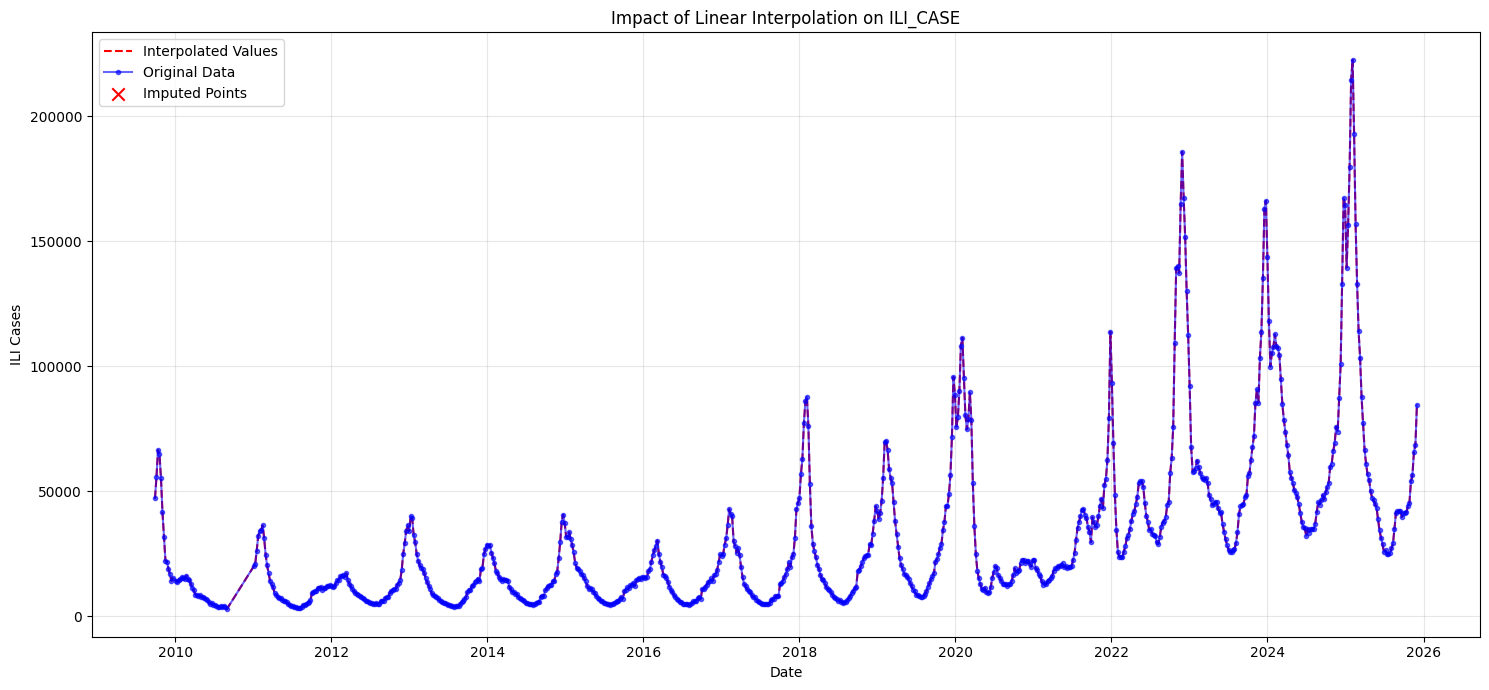

In [12]:
plt.figure(figsize=(15, 7))

plt.plot(df_model['ISO_WEEKSTARTDATE'], df_model['ILI_CASE'],
         color='red', linestyle='--', label='Interpolated Values')

plt.plot(df_model['ISO_WEEKSTARTDATE'], original_ili,
         color='blue', marker='o', markersize=3, alpha=0.6,
         label='Original Data')

missing_mask = original_ili.isna()
plt.scatter(df_model.loc[missing_mask, 'ISO_WEEKSTARTDATE'],
            df_model.loc[missing_mask, 'ILI_CASE'],
            color='red', marker='x', s=80, label='Imputed Points')

plt.title('Impact of Linear Interpolation on ILI_CASE')
plt.xlabel('Date')
plt.ylabel('ILI Cases')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [13]:
df_model['week'] = df_model['ISO_WEEKSTARTDATE'].dt.isocalendar().week.astype(int)
df_model['year'] = df_model['ISO_WEEKSTARTDATE'].dt.year

# Cyclical encoding (very important)
df_model['week_sin'] = np.sin(2 * np.pi * df_model['week'] / 52)
df_model['week_cos'] = np.cos(2 * np.pi * df_model['week'] / 52)

In [14]:
df_model['delta_1'] = df_model['ILI_CASE'] - df_model['ILI_CASE'].shift(1)
df_model['delta_2'] = df_model['ILI_CASE'] - df_model['ILI_CASE'].shift(2)


In [15]:
for lag in range(1, 9):
    df_model[f'Lag_{lag}'] = df_model['ILI_CASE'].shift(lag)

df_model = df_model.dropna()


### **STEP 3: TRAIN/TEST SPLIT**

In [16]:
train_size = int(len(df_model) * 0.8)

train = df_model.iloc[:train_size]
test = df_model.iloc[train_size:]


In [17]:
feature_cols = [
    'Lag_1','Lag_2','Lag_3','Lag_4',
    'Lag_5','Lag_6','Lag_7','Lag_8',
    'week_sin','week_cos',
    'delta_1','delta_2'
]

X_train = train[feature_cols]
y_train = train['ILI_CASE']

X_test = test[feature_cols]
y_test = test['ILI_CASE']


### **STEP 4: MODELING**

In [18]:
print("Training Random Forest Model...")
model = RandomForestRegressor(
    n_estimators=500,
    max_depth=20,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)


Training Random Forest Model...


RandomForestRegressor(max_depth=20, min_samples_leaf=5, n_estimators=500,
                      n_jobs=-1, random_state=42)

### **STEP 5: PREDICTION & EVALUATION**

In [19]:
predictions = model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100

print(f"MAE:  {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"Accuracy: {100 - mape:.2f}%")


MAE:  13,900.70
RMSE: 29,270.58
MAPE: 11.17%
Accuracy: 88.83%


In [20]:
peak_threshold = y_test.quantile(0.9)
peak_mask = y_test > peak_threshold

peak_mae = mean_absolute_error(
    y_test[peak_mask],
    predictions[peak_mask]
)

print(f"Peak MAE (top 10% weeks): {peak_mae:,.2f}")


Peak MAE (top 10% weeks): 80,181.74


### **STEP 6: VISUALIZATION**

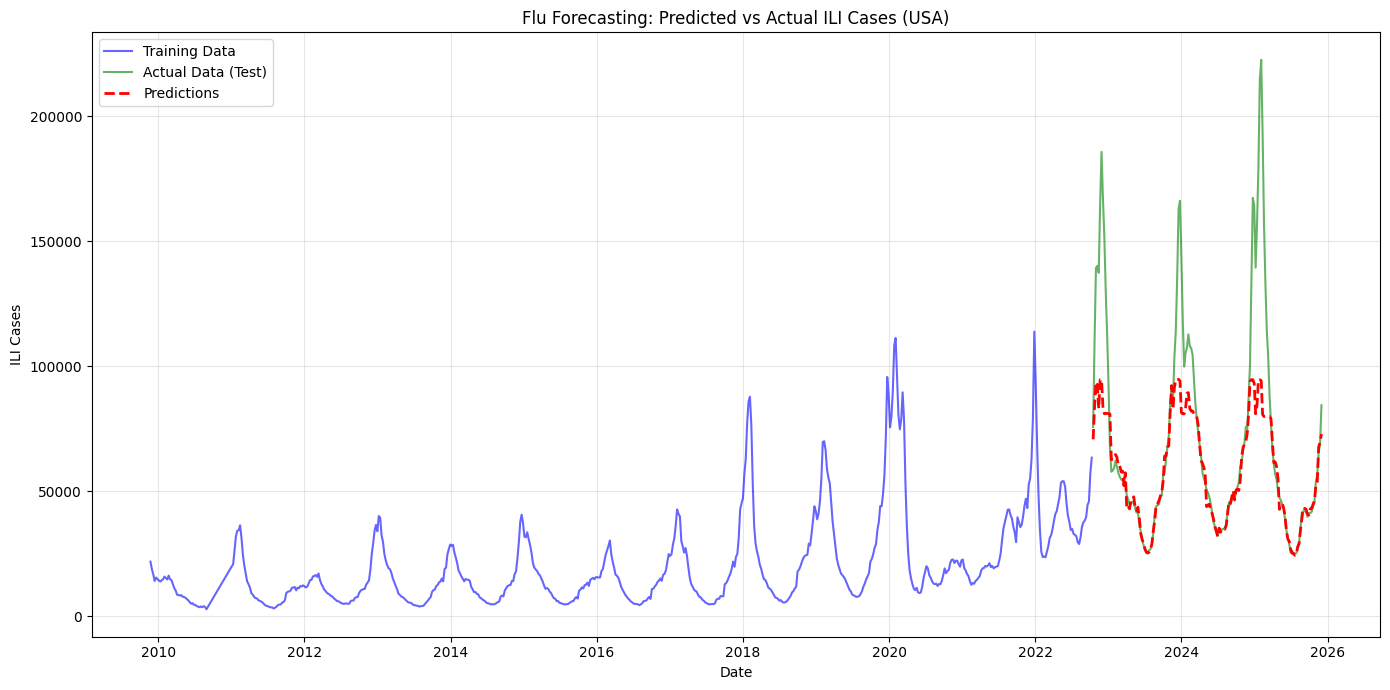

In [21]:
plt.figure(figsize=(14, 7))

plt.plot(train['ISO_WEEKSTARTDATE'], train['ILI_CASE'],
         label='Training Data', color='blue', alpha=0.6)

plt.plot(test['ISO_WEEKSTARTDATE'], y_test,
         label='Actual Data (Test)', color='green', alpha=0.6)

plt.plot(test['ISO_WEEKSTARTDATE'], predictions,
         label='Predictions', color='red', linestyle='--', linewidth=2)

plt.title('Flu Forecasting: Predicted vs Actual ILI Cases (USA)')
plt.xlabel('Date')
plt.ylabel('ILI Cases')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
